##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Regresión básica: predicción de la eficiencia del combustible

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">Ver en TensorFlow.org</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Ejecutar en Google Colab</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">Ver fuente en GitHub</a> </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/es-419/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Descargar notebook</a> </td>
</table>

En un problema de *regresión*, la meta es predecir la salida de un valor continuo, como un precio o una probabilidad. Comparemos esto con un problema de *clasificación*, donde la meta es seleccionar una clase de una lista de clases (por ejemplo, donde una imagen contiene una manzana o una naranja, reconocer qué fruta se muestra en la imagen).

Este tutorial usa el clásico conjunto de datos [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y demuestra cómo generar modelos para predecir la eficiencia del combustible de los automóviles de fines de 1970 y principios de 1980. Para ello, deberá brindarles a los modelos una descripción de muchos automóviles de ese período. Esta descripción incluye atributos como cilindros, desplazamiento, potencia y peso.

En este ejemplo se usa la API de Keras. (Visite los [tutoriales](https://www.tensorflow.org/tutorials/keras) y las [guías](https://www.tensorflow.org/guide/keras) de Keras para obtener más información).

In [1]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.18.0


## El conjunto de datos Auto MPG

El conjunto de datos está disponible desde el [repositorio UCI Machine Learning](https://archive.ics.uci.edu/ml/).


### Obtener los datos

Para empezar, use pandas para descargar e importar el conjunto de datos:

In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Limpiar los datos

El conjunto de datos contiene algunos valores desconocidos:

In [6]:
dataset.isna().sum()

,0
MPG,0
Cylinders,0
Displacement,0
Horsepower,6
Weight,0
Acceleration,0
Model Year,0
Origin,0


Descarte esas filas para simplificar este tutorial inicial:

In [7]:
.astdataset = dataset.dropna()

La columna `"Origin"` corresponde a una categoría, no es numérica. Entonces, el siguiente paso es aplicar la codificación en un solo paso de los valores en la columna con [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

Nota: Puede configurar `tf.keras.Model` para que realice este tipo de transformación por usted, pero eso está fuera del alcance de este tutorial. Consulte los tutoriales [Clasificar datos estructurados con las capas de preprocesamiento de Keras](../structured_data/preprocessing_layers.ipynb) o [Cargar datos CSV](../load_data/csv.ipynb) para ver ejemplos.

In [8]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [9]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


### Dividir los datos en conjuntos de entrenamiento y prueba

Ahora, divida los conjuntos de datos en un conjunto de entrenamiento y un conjunto de prueba. Usará el conjunto de prueba para la evaluación final de sus modelos.

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspeccionar los datos

Revise la distribución conjunta de algunos pares de columnas del conjunto de entrenamiento.

La fila superior sugiere que la eficiencia del combustible (MPG) es una función conjunta de todos los demás parámetros. Las otras filas indican que son funciones entre sí.

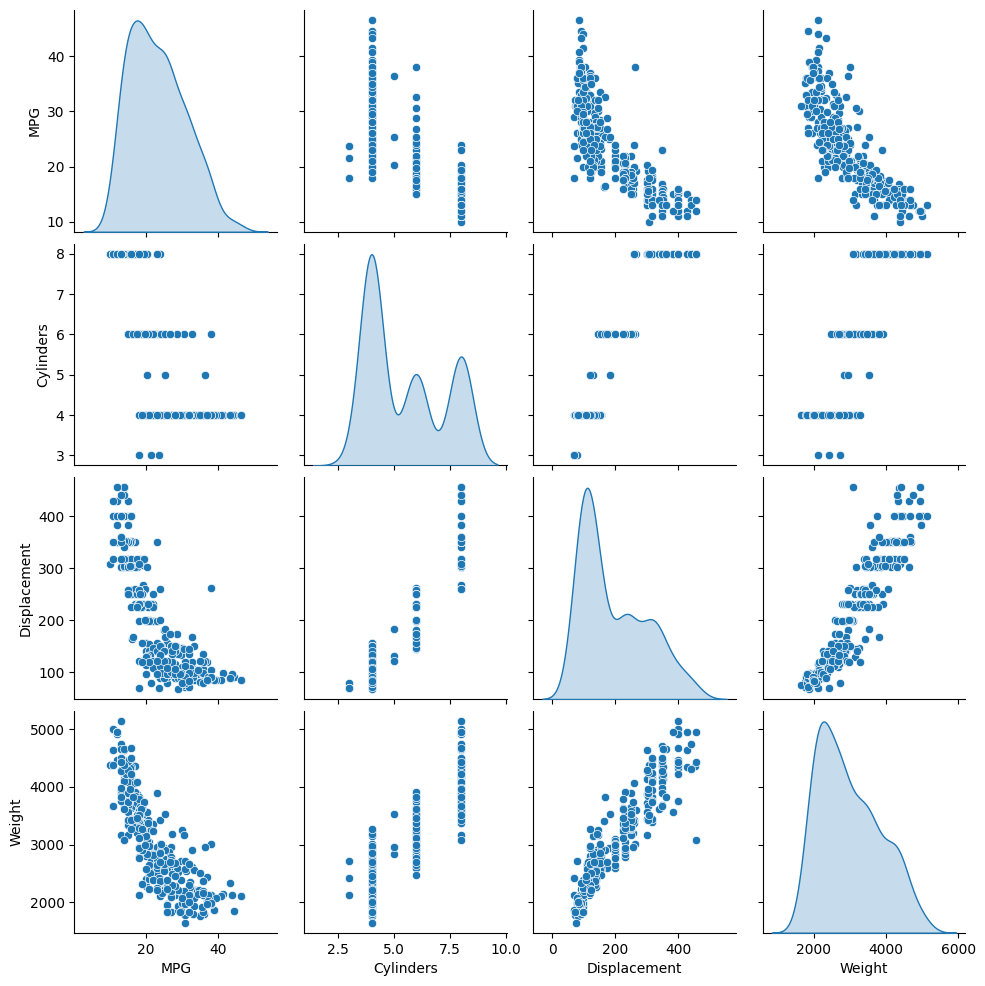

In [11]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

Comprobemos también las estadísticas generales. Observe cómo cada característica cubre un rango muy distinto:

In [12]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


### Separar las características de las etiquetas

Separe el valor de destino, la "etiqueta", de las características. Esta etiqueta es el valor que deberá predecir el modelo entrenado.

In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalización

En la tabla de estadísticas se puede ver con claridad lo distintos que son los rangos de cada característica:

In [14]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


Resulta muy práctico normalizar características que usan diferentes escalas y rangos.

Uno de los motivos por los que esto resulta importante es que las características se multiplican por los pesos del modelo. Por lo tanto, la escala de las salidas y la escala de los gradientes se ve afectada por la escala de las entradas.

Si bien un modelo *podría* converger sin implementar la normalización de las características, dicha normalización le aporta más estabilidad al entrenamiento.

Nota: Normalizar las características de codificación en un solo paso no presenta ninguna ventaja, solo se hace aquí para simplificar. Si desea obtener más información sobre cómo se usan las capas de preprocesamiento, consulte la guía [Trabajar con capas de preprocesamiento](https://www.tensorflow.org/guide/keras/preprocessing_layers) y el tutorial [Clasificar datos estructurados con las capas de preprocesamiento de Keras](../structured_data/preprocessing_layers.ipynb).

### La capa de normalización

`tf.keras.layers.Normalization` presenta un método simple y directo de agregar normalización de características a su modelo.

El primer paso consiste en crear la capa:

In [15]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Luego, debe llamar `Normalization.adapt` para ajustar el estado de la capa de preprocesamiento a los datos:

In [16]:
normalizer.adapt(np.array(train_features))

Calcule la media y la desviación, y almacénelas en la capa:

In [17]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


Cuando se llama a la capa, esta devuelve los datos de entrada, con cada característica normalizada de forma independiente:

In [20]:
first = np.array(train_features[:1]).astype(np.float32)

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Regresión lineal

Antes de generar un modelo de red neuronal profunda, comience con la regresión lineal y use una y varias variables.

### Regresión lineal con una variable

Comience por aplicar una regresión lineal de una sola variable para predecir `'MPG'` a partir de `'Horsepower'`.

Al entrenar un modelo con `tf.keras` generalmente se comienza por definir la arquitectura del modelo. Use un modelo `tf.keras.Sequential`, que [representa una secuencia de pasos](https://www.tensorflow.org/guide/keras/sequential_model).

Un modelo de regresión lineal de una variable consta de dos pasos:

- Normalice las características de la entrada `'Horsepower'` mediante el uso de la capa de preprocesamiento `tf.keras.layers.Normalization`.
- Aplique una transformación lineal ($y = mx+b$) para producir 1 salida mediante el uso de una capa lineal (`tf.keras.layers.Dense`).

La cantidad de *entradas* se pueden establecer tanto mediante el argumento `input_shape` como de forma automática cuando el modelo se ejecute por primera vez.

En primer lugar, cree un arreglo NumPy compuesto por las características de `'Horsepower'`. Luego, cree instancias de `tf.keras.layers.Normalization` y ajuste su estado a los datos de `horsepower`:

In [21]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generar el modelo secuencial de Keras:

In [22]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

Este modelo puede predecir `'MPG'` a partir de `'Horsepower'`.

Ejecute el modelo sin entrenar en los primeros 10 valores de 'Horsepower'. La salida no será buena, pero observe que tiene la forma esperada de `(10, 1)`:

In [23]:
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


array([[-0.2  ],
       [-0.113],
       [ 0.369],
       [-0.28 ],
       [-0.253],
       [-0.1  ],
       [-0.3  ],
       [-0.253],
       [-0.066],
       [-0.113]], dtype=float32)

Una vez que se haya generado el modelo, configure el procedimiento de entrenamiento a través del método `Model.compile` de Keras. Los argumentos más importantes para compilar son `loss` y `optimizer`, ya que estos definen qué se optimizará (`mean_absolute_error`) y cómo (mediante el uso de `tf.keras.optimizers.Adam`).

In [24]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Use `Model.fit` de Keras para ejecutar el entrenamiento durante 100 épocas:

In [25]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 8.07 s, sys: 295 ms, total: 8.36 s
Wall time: 10.7 s


Visualice el progreso del entrenamiento del modelo con ayuda de las estadísticas almacenadas en el objeto `history`:

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.803362,4.182890,95
96,3.804049,4.195126,96
97,3.802069,4.183576,97
98,3.807860,4.208828,98
99,3.802629,4.180423,99


In [27]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

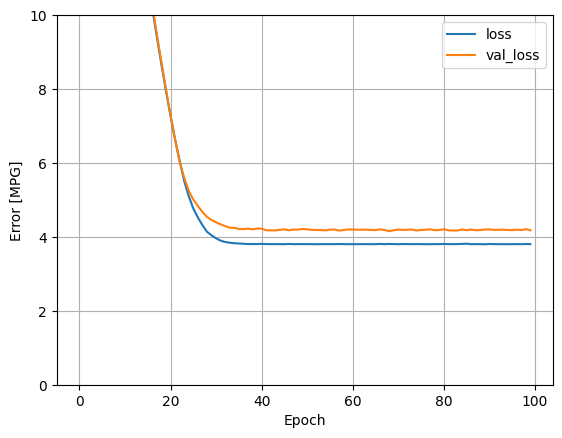

In [28]:
plot_loss(history)

Recopile los resultados del conjunto de prueba para después:

In [29]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

Como se trata de una regresión lineal con una sola variable, es fácil ver las predicciones del modelo como una función de la entrada:

In [30]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [31]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

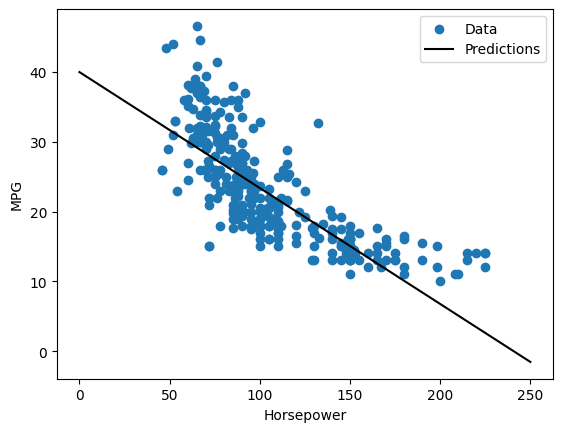

In [32]:
plot_horsepower(x, y)

### Regresión lineal con múltiples entradas

Puede usar una configuración prácticamente idéntica para hacer predicciones basadas en múltiples entradas. Este modelo hace lo mismo que $y = mx+b$ con la diferencia de que $m$ es una matriz y $x$ es un vector.

Cree un modelo secuencial de Keras nuevamente donde la primera capa sea `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) que anteriormente ya definió y adaptó a todo el conjunto de datos:

In [33]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

Cuando llama `Model.predict` en un lote de entradas, produce salidas `units=1` para cada ejemplo:

In [34]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


array([[-1.397],
       [-0.057],
       [ 1.636],
       [-1.716],
       [-0.845],
       [ 0.5  ],
       [-0.842],
       [ 1.407],
       [ 0.424],
       [-0.057]], dtype=float32)

Cuando llama el modelo, sus matrices de peso se generarán; compruebe que los pesos `kernel` (the $m$ in $y=mx+b$) tengan la misma forma que `(9, 1)`:

In [35]:
linear_model.layers[1].kernel

<Variable path=sequential_1/dense_1/kernel, shape=(9, 1), dtype=float32, value=[[ 0.299]
 [-0.126]
 [ 0.316]
 [ 0.774]
 [ 0.746]
 [-0.117]
 [ 0.518]
 [ 0.427]
 [ 0.587]]>

Configure el modelo con Keras `Model.compile` y entrénelo con `Model.fit` durante 100 épocas:

In [36]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [37]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 9.32 s, sys: 372 ms, total: 9.69 s
Wall time: 14.1 s


Usar todas las entradas en este modelo de regresión consigue un error de entrenamiento y validación mucho más bajo que `horsepower_model`, que tenía una sola entrada:

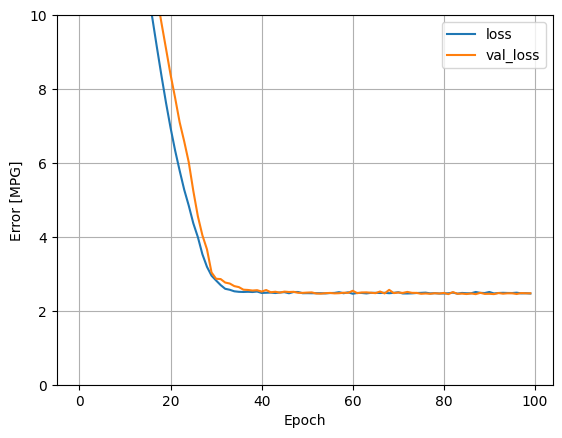

In [38]:
plot_loss(history)

Recopile los resultados del conjunto de prueba para después:

In [39]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Regresión con una red neuronal profunda (DNN)

En la sección anterior, implementó dos modelos lineales tanto con una entrada como con múltiples entradas.

Aquí, implementará modelos de DNN de una sola entrada y de múltiples entradas.

El código es básicamente el mismo, con la diferencia de que el modelo se amplió para incluir algunas capas no lineales "ocultas". Con el término "ocultas" nos referimos a que no están directamente conectadas con las entradas y las salidas.

Estos modelos contendrán algunas capas más que el modelo lineal:

- La capa de normalización, de la misma forma que sucedió anteriormente (con `horsepower_normalizer` para un modelo de una sola entrada y `normalizer` para un modelo con múltiples entradas).
- Dos capas `Dense` ocultas, no lineales con la función de activación no lineal ReLU (`relu`).
- Una capa `Dense` lineal de una sola salida.

Ambos modelos usarán el mismo procedimiento de entrenamiento, por lo que el método `compile` se incluye en la función `build_and_compile_model` a continuación.

In [40]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regresión usando una DNN y una sola entrada

Cree un modelo de DNN con solo `'Horsepower'` como entrada y `horsepower_normalizer` (definido anteriormente) como capa de normalización:

In [41]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

Este modelo tiene bastantes parámetros entrenables más que el modelo lineal:

In [42]:
dnn_horsepower_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

Entrene el modelo con `Model.fit` de Keras:

In [43]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 10 s, sys: 476 ms, total: 10.5 s
Wall time: 13.6 s


Este modelo tiene un rendimiento ligeramente superior al modelo lineal `horsepower_model` de una sola entrada:

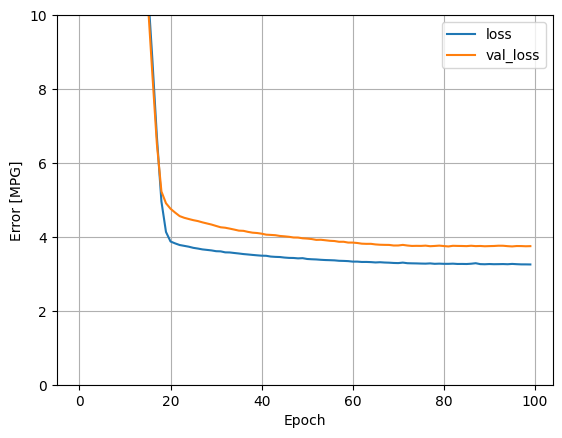

In [44]:
plot_loss(history)

Si traza estas predicciones como una función de `'Horsepower'`, notará que este modelo aprovecha la falta de linealidad que le aportan las capas ocultas:

In [45]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


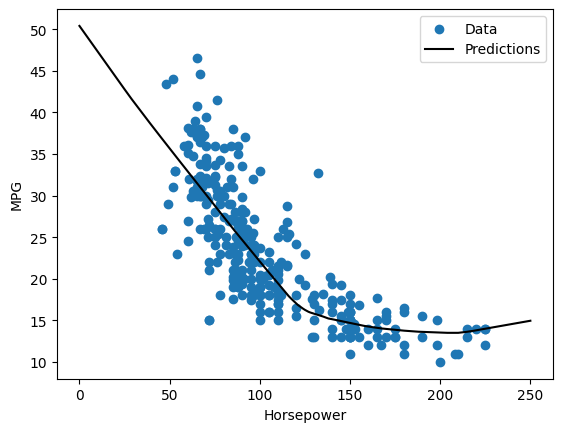

In [46]:
plot_horsepower(x, y)

Recopile los resultados del conjunto de prueba para después:

In [47]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### Regresión usando una DNN y múltiples entradas

Repita el proceso anterior usando todas las entradas. El rendimiento del modelo mejora levemente con el conjunto de datos de validación.

In [48]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (10, 9)                │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [49]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 9.72 s, sys: 430 ms, total: 10.2 s
Wall time: 13.7 s


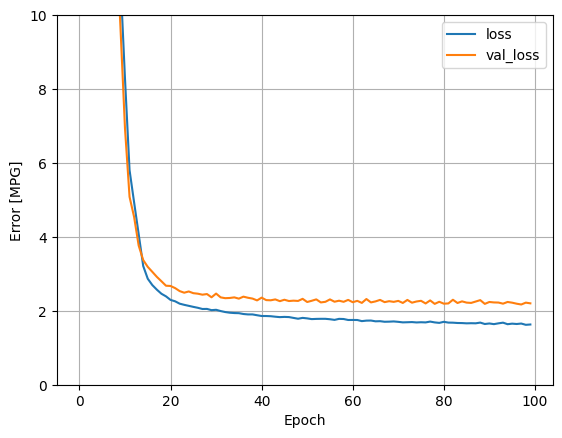

In [50]:
plot_loss(history)

Recopile los resultados del conjunto de prueba:

In [51]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Rendimiento

Dado que ya ha entrenado todos los modelos, puede consultar el rendimiento del conjunto de prueba:

In [52]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.654140
linear_model,2.493704
dnn_horsepower_model,2.933943
dnn_model,1.760839


Estos resultados coinciden con el error de validación que se observó durante el entrenamiento.

### Hacer predicciones

Ahora puede hacer predicciones con `dnn_model` en el conjunto de prueba usando Keras `Model.predict` y revisar la pérdida:

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


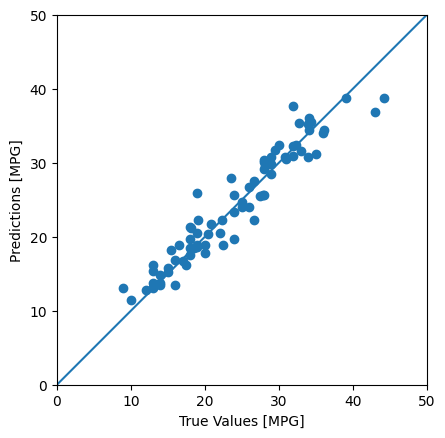

In [53]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Al parecer, el modelo predice bastante bien.

Ahora, compruebe la distribución de los errores:

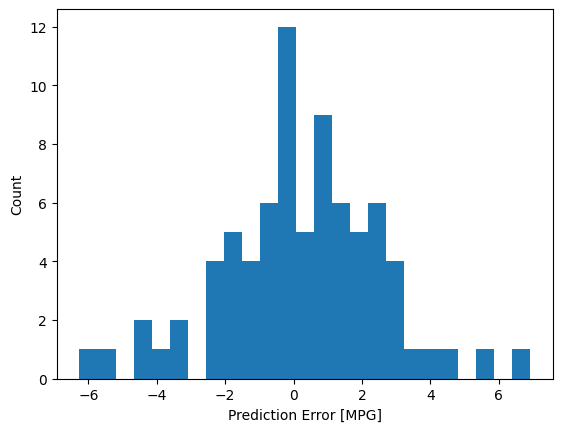

In [54]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

Si está satisfecho con el modelo, guárdelo para usarlo más tarde con `Model.save`:

In [55]:
dnn_model.save('dnn_model.keras')

Si vuelve a cargar el modelo, le da una salida idéntica:

In [56]:
reloaded = tf.keras.models.load_model('dnn_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [57]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.654140
linear_model,2.493704
dnn_horsepower_model,2.933943
dnn_model,1.760839
reloaded,1.760839


## Conclusión

Este bloc de notas introdujo algunas técnicas para hacer frente a un problema de regresión. Aquí encontrará algunos consejos más que pueden ayudarle:

- El error cuadrático medio (MSE) (`tf.keras.losses.MeanSquaredError`) y el error absoluto medio (MAE) (`tf.keras.losses.MeanAbsoluteError`) son funciones de pérdida comunes que se usan para problemas de regresión. MAE es menos susceptible a los valores atípicos. Para los problemas de clasificación se usan otras funciones de pérdida.
- Asimismo, las métricas de evaluación que se usan para la regresión son distintas de las que se usan para la clasificación.
- Cuando las características de los datos de entradas numéricas tienen valores con diferentes rangos, se debe escalar por separado cada característica al mismo rango.
- El sobreajuste es un problema común para los modelos de DNN, aunque no fue un problema para este tutorial. Visite el tutorial [Sobreajuste y subajuste](overfit_and_underfit.ipynb) para obtener más ayuda al respecto.